<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
### <font color='blue'>Modelagem de Séries Temporais e Real-Time Analytics com Apache Spark e Databricks</font>
### <font color='blue'>Projeto 1 - Tarefa 7</font>
### <font color='blue'>Prevendo Usuários Ativos em Um Web Site</font>

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [1]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando e Preparando os Dados

In [3]:
# Carrega os dados
df_dsa = pd.read_csv("dataset_per_hour.csv")
df_dsa_novos_dados = pd.read_csv("novos_dados.csv")

Vamos ajustar a coluna de data para o tipo adequado.

In [4]:
# Converte a coluna de data para o tipo correto
df_dsa['data'] = pd.to_datetime(df_dsa.data, format = '%d-%m-%Y %H:%M')

In [5]:
# Converte a coluna de data para o tipo correto
df_dsa_novos_dados['data'] = pd.to_datetime(df_dsa_novos_dados.data, format = '%d-%m-%Y %H:%M')

In [6]:
# Definimos o índice do dataset
df_dsa.index = df_dsa['data']

In [7]:
# Removemos a coluna ID, pois ela não é relevante neste caso
df_dsa.drop('id', axis = 1, inplace = True)

In [8]:
# Removemos a coluna data, pois ela não é relevante neste caso
df_dsa.drop('data', axis = 1, inplace = True)

In [9]:
# Variável target 
target = df_dsa['usuarios_ativos']

In [10]:
# Vejamos como ficou o dataset
df_dsa.head()

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


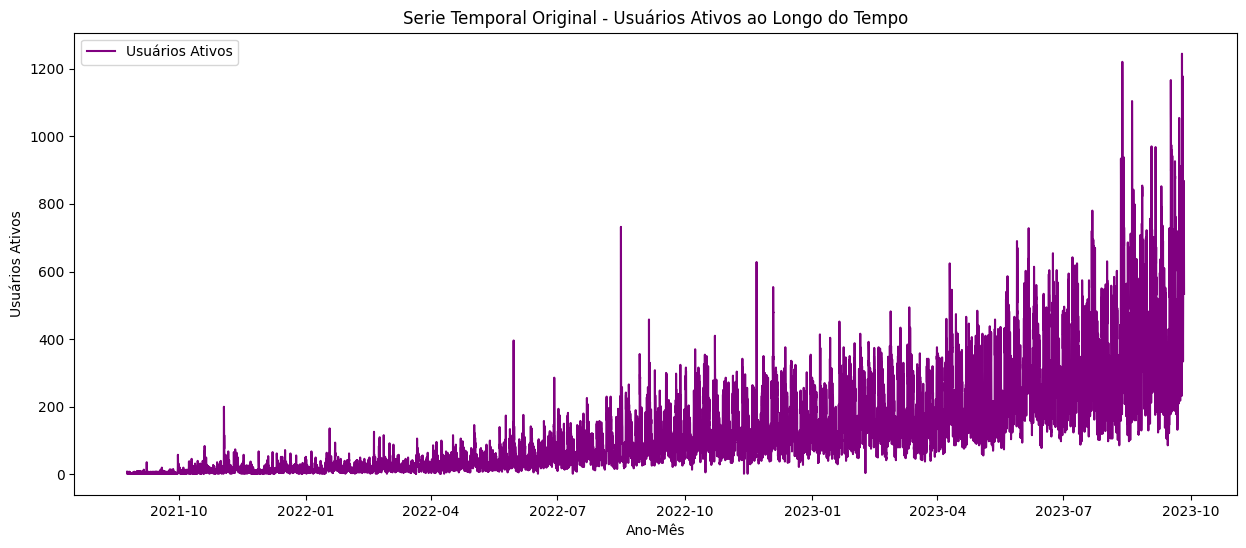

In [11]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal Original - Usuários Ativos ao Longo do Tempo")
plt.plot(target, label = "Usuários Ativos", color = 'purple')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

## Pré-Processamento

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo.

Observe que os registros são separados em ordem cronológica.

In [12]:
# Os dados de treino serão divididos em dados de treino e validação
df_treino = df_dsa.iloc[0:16057]
df_valid = df_dsa.iloc[16058:]

In [13]:
# Os dados devem estar no formato NumPy para o treino do modelo
array_dados_treino = np.asarray(df_treino['usuarios_ativos'])

In [14]:
type(array_dados_treino)

numpy.ndarray

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Implementando a Estratégia 2 de Forecasting - Exponential Smoothing

Exponential Smoothing é uma técnica de modelagem de séries temporais que utiliza uma média móvel ponderada para prever valores futuros de uma série temporal. Cada ponto de dado é atribuído com um peso exponencial decrescente, com os pontos mais recentes recebendo mais peso e os pontos mais antigos recebendo menos peso. O resultado é uma previsão suavizada que leva em consideração tanto a tendência geral quanto a sazonalidade da série temporal.

Vamos criar dois modelos de Suavização Exponencial usando o Statsmodels.

#### Simple Exponential Smoothing

Veja a descrição no videobook no Capítulo 6.

In [15]:
# Versão 1 do modelo - Simple Exponential Smoothing
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html

# A função SimpleExpSmoothing() recebe os dados de treino no formato de array numpy
# A função fit() faz o treinamento

# O hiperparâmetro smoothing_level define o nível de suavização exponencial na série
# O hiperparâmetro optimized define se teremos ou não otimização 

# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(array_dados_treino).fit(smoothing_level = 0.2, optimized = True)

In [16]:
# Previsões com o Modelo
df_valid['previsoes_v1'] = modelo_v1.forecast(len(df_valid)) 

In [17]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['usuarios_ativos', 'previsoes_v1']].head()

,usuarios_ativos,previsoes_v1
data,,
2023-06-25 02:00:00,218,395.388938
2023-06-25 03:00:00,244,395.388938
2023-06-25 04:00:00,168,395.388938
2023-06-25 05:00:00,140,395.388938
2023-06-25 06:00:00,156,395.388938


In [19]:
df_valid.previsoes_v1.unique()

array([395.38893762])

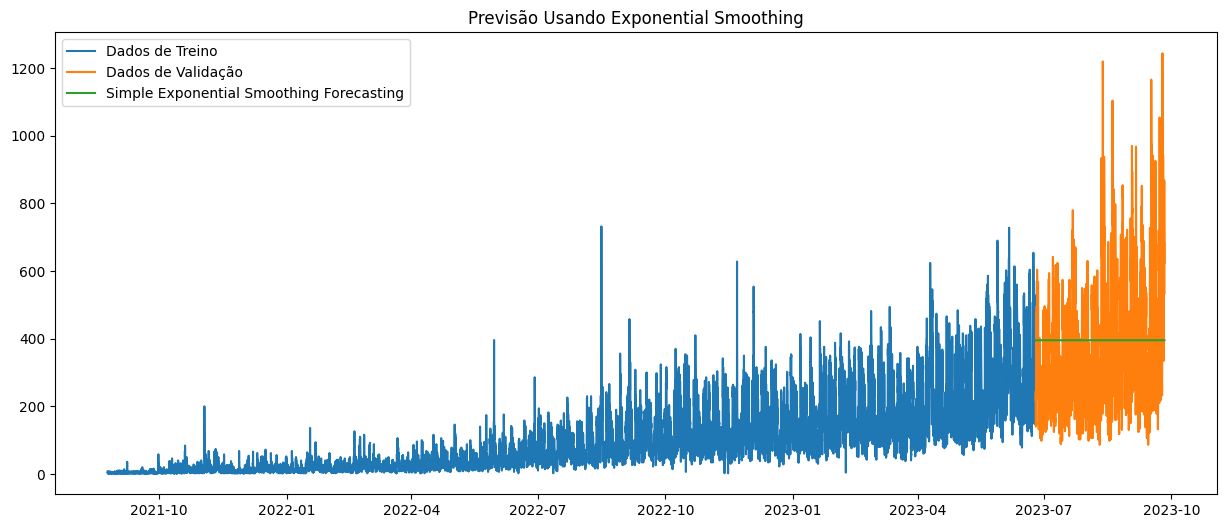

In [20]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['usuarios_ativos'], label = 'Dados de Treino')
plt.plot(df_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

Visualmente não parece ter tanta diferença para nosso modelo base do Projeto. Vamos calcular o erro do modelo.

In [21]:
# Define valor real e valor previsto
y_true = df_valid.usuarios_ativos
y_pred = df_valid.previsoes_v1

In [22]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

186.52867297329848


Reduzimos o erro em relação ao modelo com método Naive. Ou seja, já temos uma forma de fazer previsões um pouco melhores.

Nosso objetivo é reduzir o RMSE tanto quanto possível, pois essa métrica indica a taxa de erro do modelo.

Será que conseguimos melhorar a performance do modelo? Vamos tentar outro tipo de suavização exponencial.

#### Double Exponential Smoothing 

Veja a descrição no videobook no Capítulo 6.

In [23]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como não temos sazonalidade na série, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(df_treino['usuarios_ativos']), 
                                 trend = 'additive').fit(smoothing_level = 0.9, 
                                                         optimized = True) 

In [24]:
# Previsões com o Modelo
df_valid.loc[:,'previsoes_v2'] = modelo_v2.forecast(len(df_valid))

In [25]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid[['usuarios_ativos', 'previsoes_v1', 'previsoes_v2']].head()

,usuarios_ativos,previsoes_v1,previsoes_v2
data,,,
2023-06-25 02:00:00,218,395.388938,337.500448
2023-06-25 03:00:00,244,395.388938,337.521154
2023-06-25 04:00:00,168,395.388938,337.541860
2023-06-25 05:00:00,140,395.388938,337.562566
2023-06-25 06:00:00,156,395.388938,337.583272


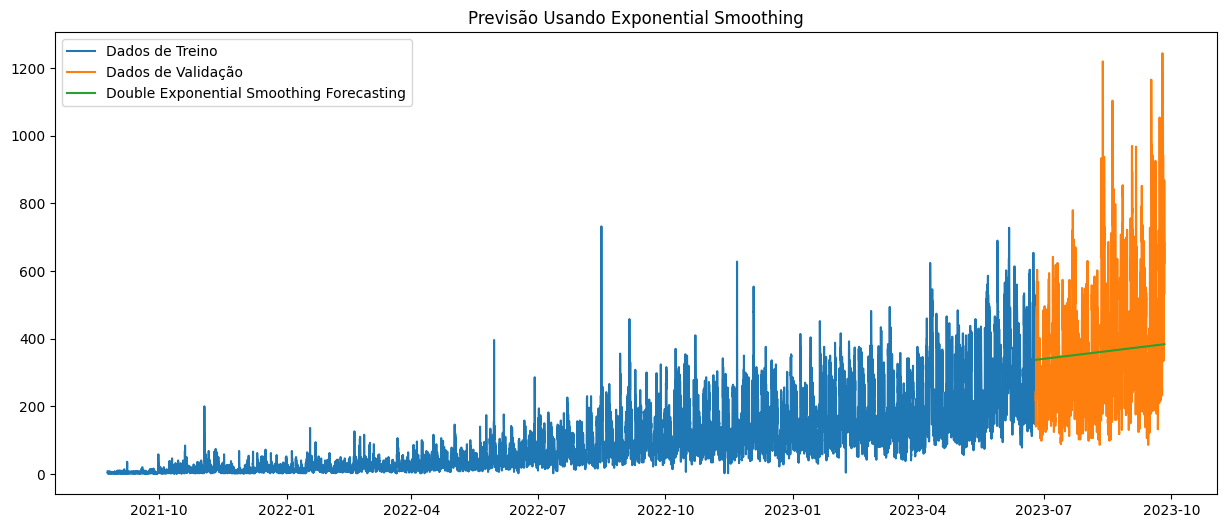

In [26]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(df_treino['usuarios_ativos'], label = 'Dados de Treino')
plt.plot(df_valid['usuarios_ativos'], label = 'Dados de Validação')
plt.plot(df_valid['previsoes_v2'], label = 'Double Exponential Smoothing Forecasting') 
plt.legend(loc = 'best') 
plt.show()

In [27]:
# Define valor real e valor previsto
y_true = df_valid.usuarios_ativos
y_pred = df_valid.previsoes_v2

In [28]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

184.99235082525715


Conseguimos um ganho um pouco mais efetivo. A linha de previsão mudou, seguindo um pouco mais o padrão nos dados, e o erro do modelo caiu um pouco mais.

Ainda assim as técnicas de suavização apresentaram um resultado apenas levemente superior ao modelo base. Vamos tentar melhorar isso com modelos ARIMA.

In [30]:
# %reload_ext watermark
# %watermark -a "Data Science Academy"

In [29]:
#%watermark -v -m

In [30]:
#%watermark --iversions

# Fim